In [29]:
# %load withholding.py
%matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

import seaborn as sns
# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float('nan')])

def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert(np.sum(activations) == row.number_activations or row.error)
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d['attacker_compute'] = rcompute[0]
    d['attacker_relative_activations'] = ractivations[0]
    d['attacker_relative_reward'] = rreward[0]
    d['attacker_gain'] = rreward[0] - ractivations[0]
    d['attacker_reward'] = reward[0]
    d['attacker_reward_per_time'] = reward[0] / row.ca_time
    # simulate DAA restrospectively. This method works only for zero network delays.
    d['da_observed_pow_interval'] = row.ca_time / (row.ca_height * row.k)
    d['da_target_pow_interval'] = 1
    d['da_ca_time'] = row.ca_time / d['da_observed_pow_interval'] * d['da_target_pow_interval']
    d['da_attacker_reward_per_time'] = reward[0] / d['da_ca_time']
    return d

df=df.join(df.apply(expand, axis=1, result_type='expand'))

d = df[df.protocol == "george"]
d = d[(d.incentive_scheme == 'constant') | (d.incentive_scheme == 'discount')]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'ca_time', 'ca_height', 'machine_duration_s', 'error',
       'attacker_compute', 'attacker_relative_activations',
       'attacker_relative_reward', 'attacker_gain', 'attacker_reward',
       'attacker_reward_per_time', 'da_observed_pow_interval',
       'da_target_pow_interval', 'da_ca_time', 'da_attacker_reward_per_time'],
      dtype='object')

In [16]:
d.pivot(index=['attacker_compute', 'k'], columns=['strategy', 'incentive_scheme'], values='attacker_relative_reward')

strategy             private-override-catchup            \
incentive_scheme                     constant  discount   
attacker_compute k                                        
0.10             1                   0.035748  0.035748   
                 2                   0.007885  0.007885   
                 4                   0.000684  0.000666   
                 8                   0.000011  0.000011   
                 16                  0.000000  0.000000   
                 32                  0.000000  0.000000   
                 64                  0.000000  0.000000   
                 128                 0.000000  0.000000   
0.20             1                   0.129487  0.129487   
                 2                   0.058228  0.058228   
                 4                   0.018967  0.018417   
                 8                   0.003453  0.003293   
                 16                  0.000204  0.000195   
                 32                  0.000000  0.000000   
                 64                  0.000000  0.000000   
                 128                 0.000000  0.000000   
0.25             1                   0.194597  0.194597   
                 2                   0.108045  0.108045   
                 4                   0.052658  0.051065   
                 8                   0.017538  0.016705   
                 16                  0.002925  0.002781   
                 32                  0.000112  0.000104   
                 64                  0.000000  0.000000   
                 128                 0.000000  0.000000   
0.33             1                   0.327616  0.327616   
                 2                   0.223539  0.223539   
                 4                   0.156543  0.152742   
                 8                   0.103721  0.099295   
                 16                  0.055065  0.052054   
                 32                  0.017308  0.016157   
                 64                  0.001969  0.001852   
                 128                 0.000000  0.000000   
0.40             1                   0.482805  0.482805   
                 2                   0.370674  0.370674   
                 4                   0.305844  0.300909   
                 8                   0.269511  0.262189   
                 16                  0.244731  0.236800   
                 32                  0.201481  0.193476   
                 64                  0.158942  0.150651   
                 128                 0.090341  0.084157   
0.45             1                   0.631321  0.631321   
                 2                   0.527202  0.527202   
                 4                   0.459857  0.456480   
                 8                   0.434588  0.430073   
                 16                  0.452074  0.450682   
                 32                  0.493414  0.499569   
                 64                  0.563426  0.583883   
                 128                 0.645532  0.689888   
0.50             1                   0.809376  0.809376   
                 2                   0.800162  0.800162   
                 4                   0.799457  0.801029   
                 8                   0.801996  0.809228   
                 16                  0.837801  0.854821   
                 32                  0.790311  0.827277   
                 64                  0.741325  0.800937   
                 128                 0.748031  0.816514   

strategy             private-override-block-alt            \
incentive_scheme                       constant  discount   
attacker_compute k                                          
0.10             1                     0.034978  0.034978   
                 2                     0.024406  0.024406   
                 4                     0.015972  0.015280   
                 8                     0.012749  0.011857   
                 16                    0.012930  0.011914   
                 32           

<IPython.core.display.Javascript object>


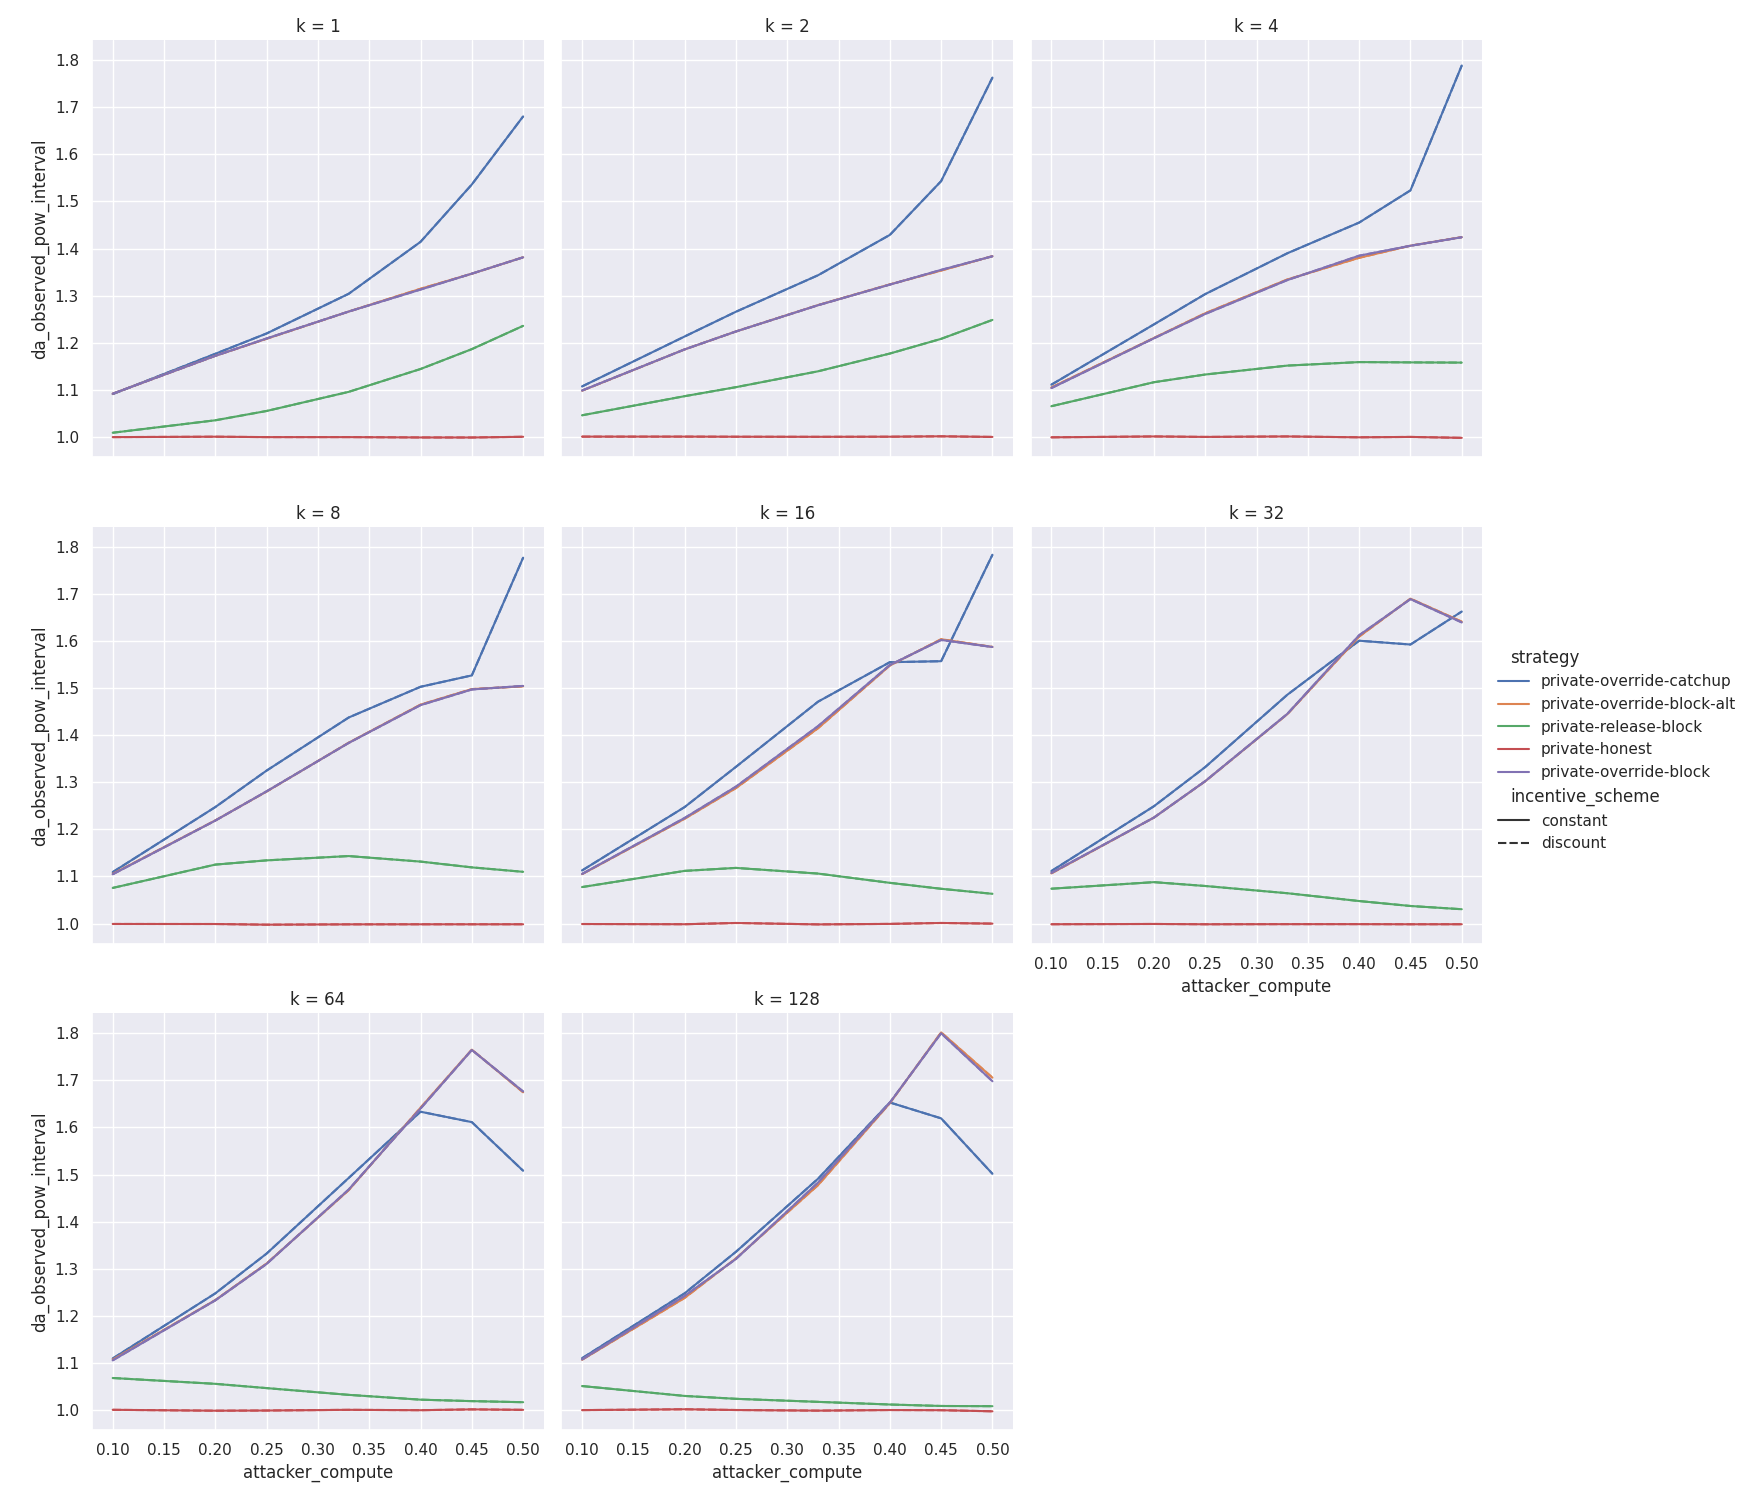

In [30]:
ax = sns.relplot(
    data=d,
    x="attacker_compute", y="da_observed_pow_interval", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)

<IPython.core.display.Javascript object>


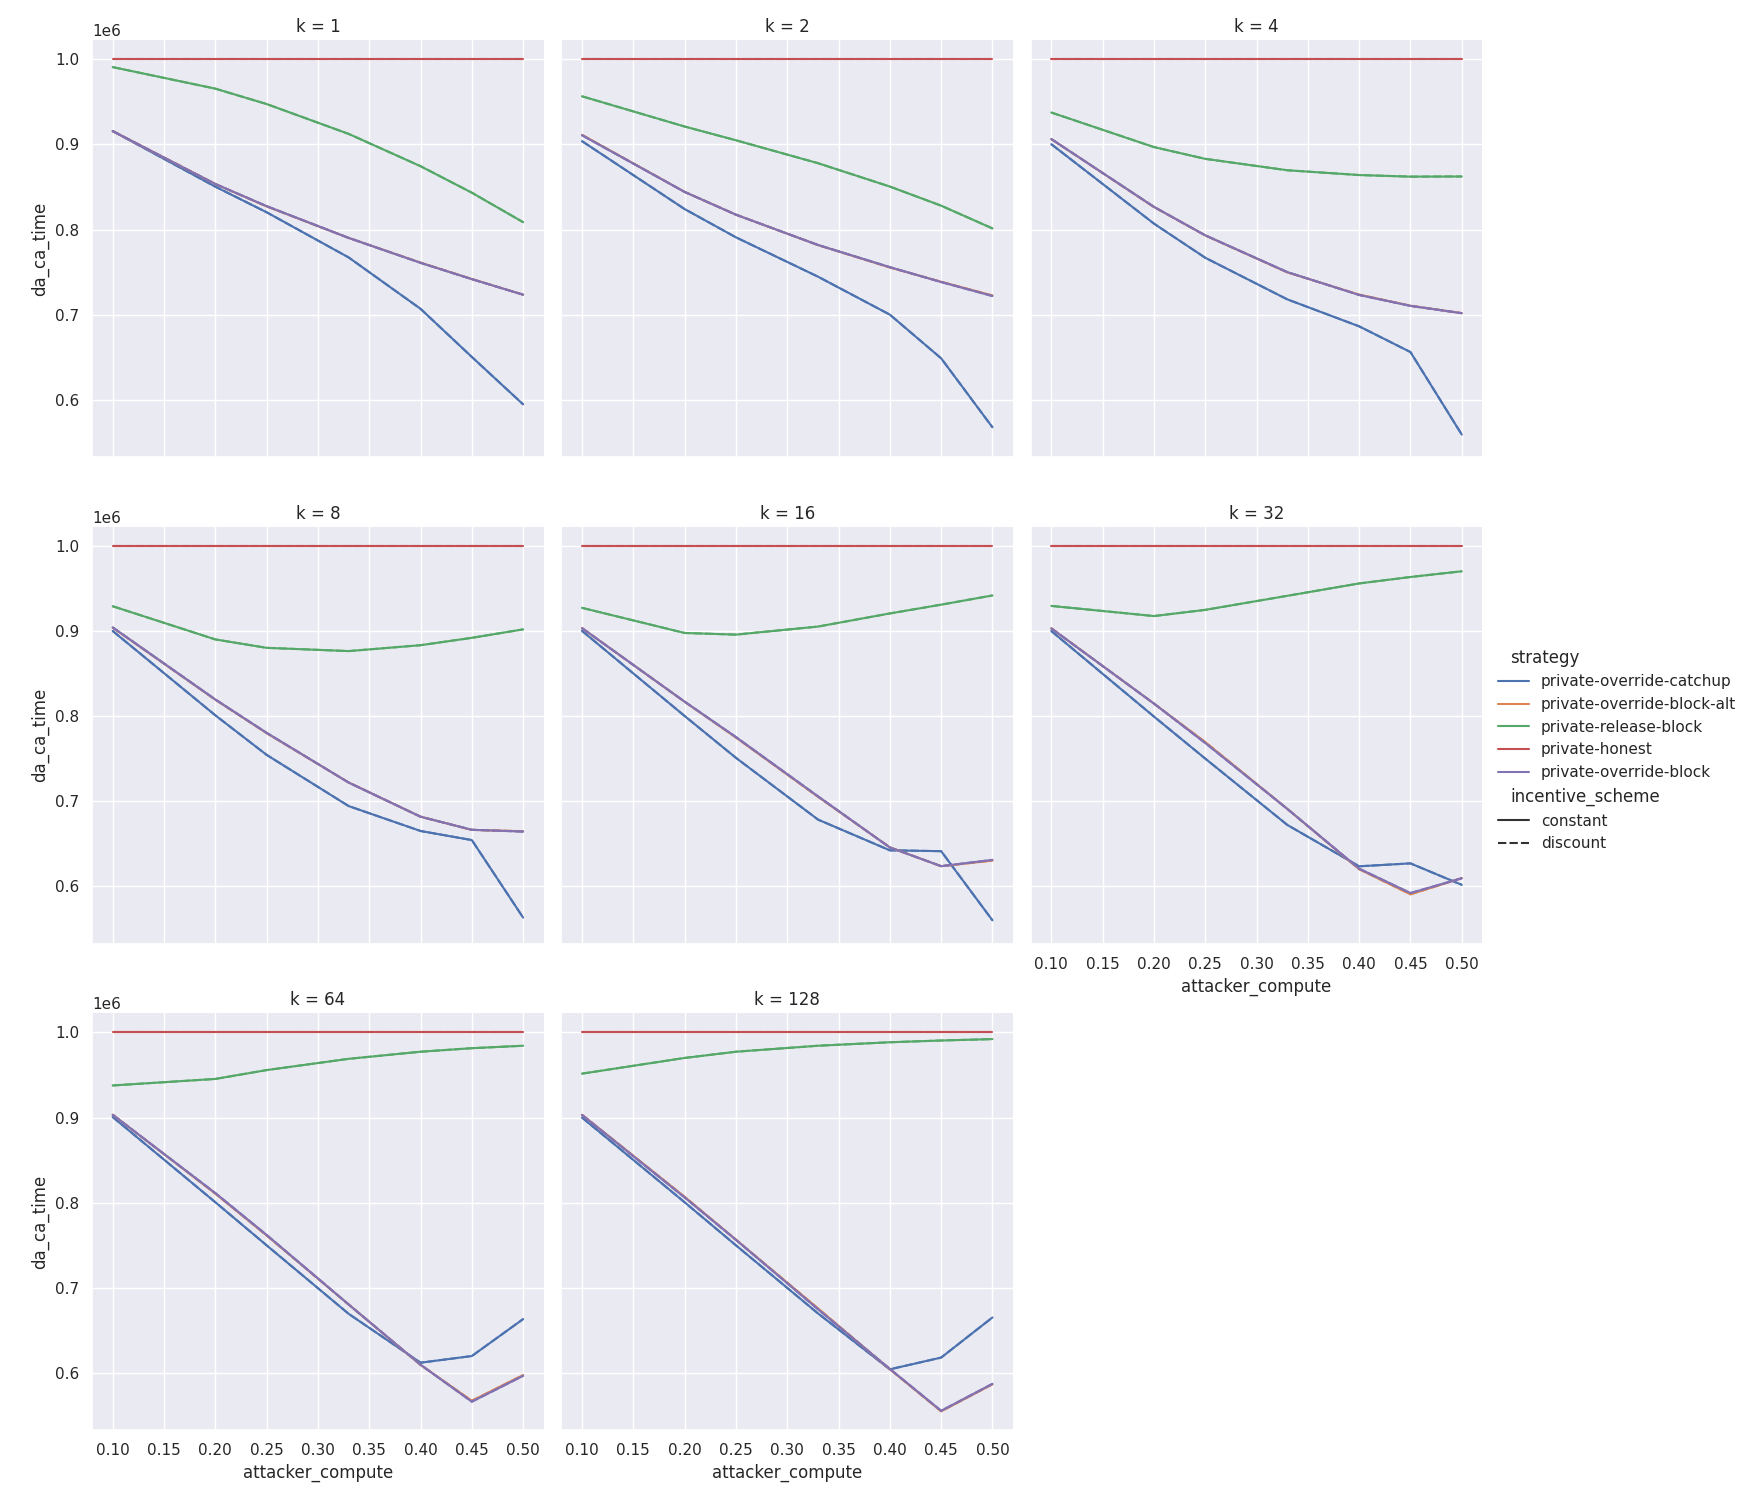

In [31]:
ax = sns.relplot(
    data=d,
    x="attacker_compute", y="da_ca_time", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)

<IPython.core.display.Javascript object>


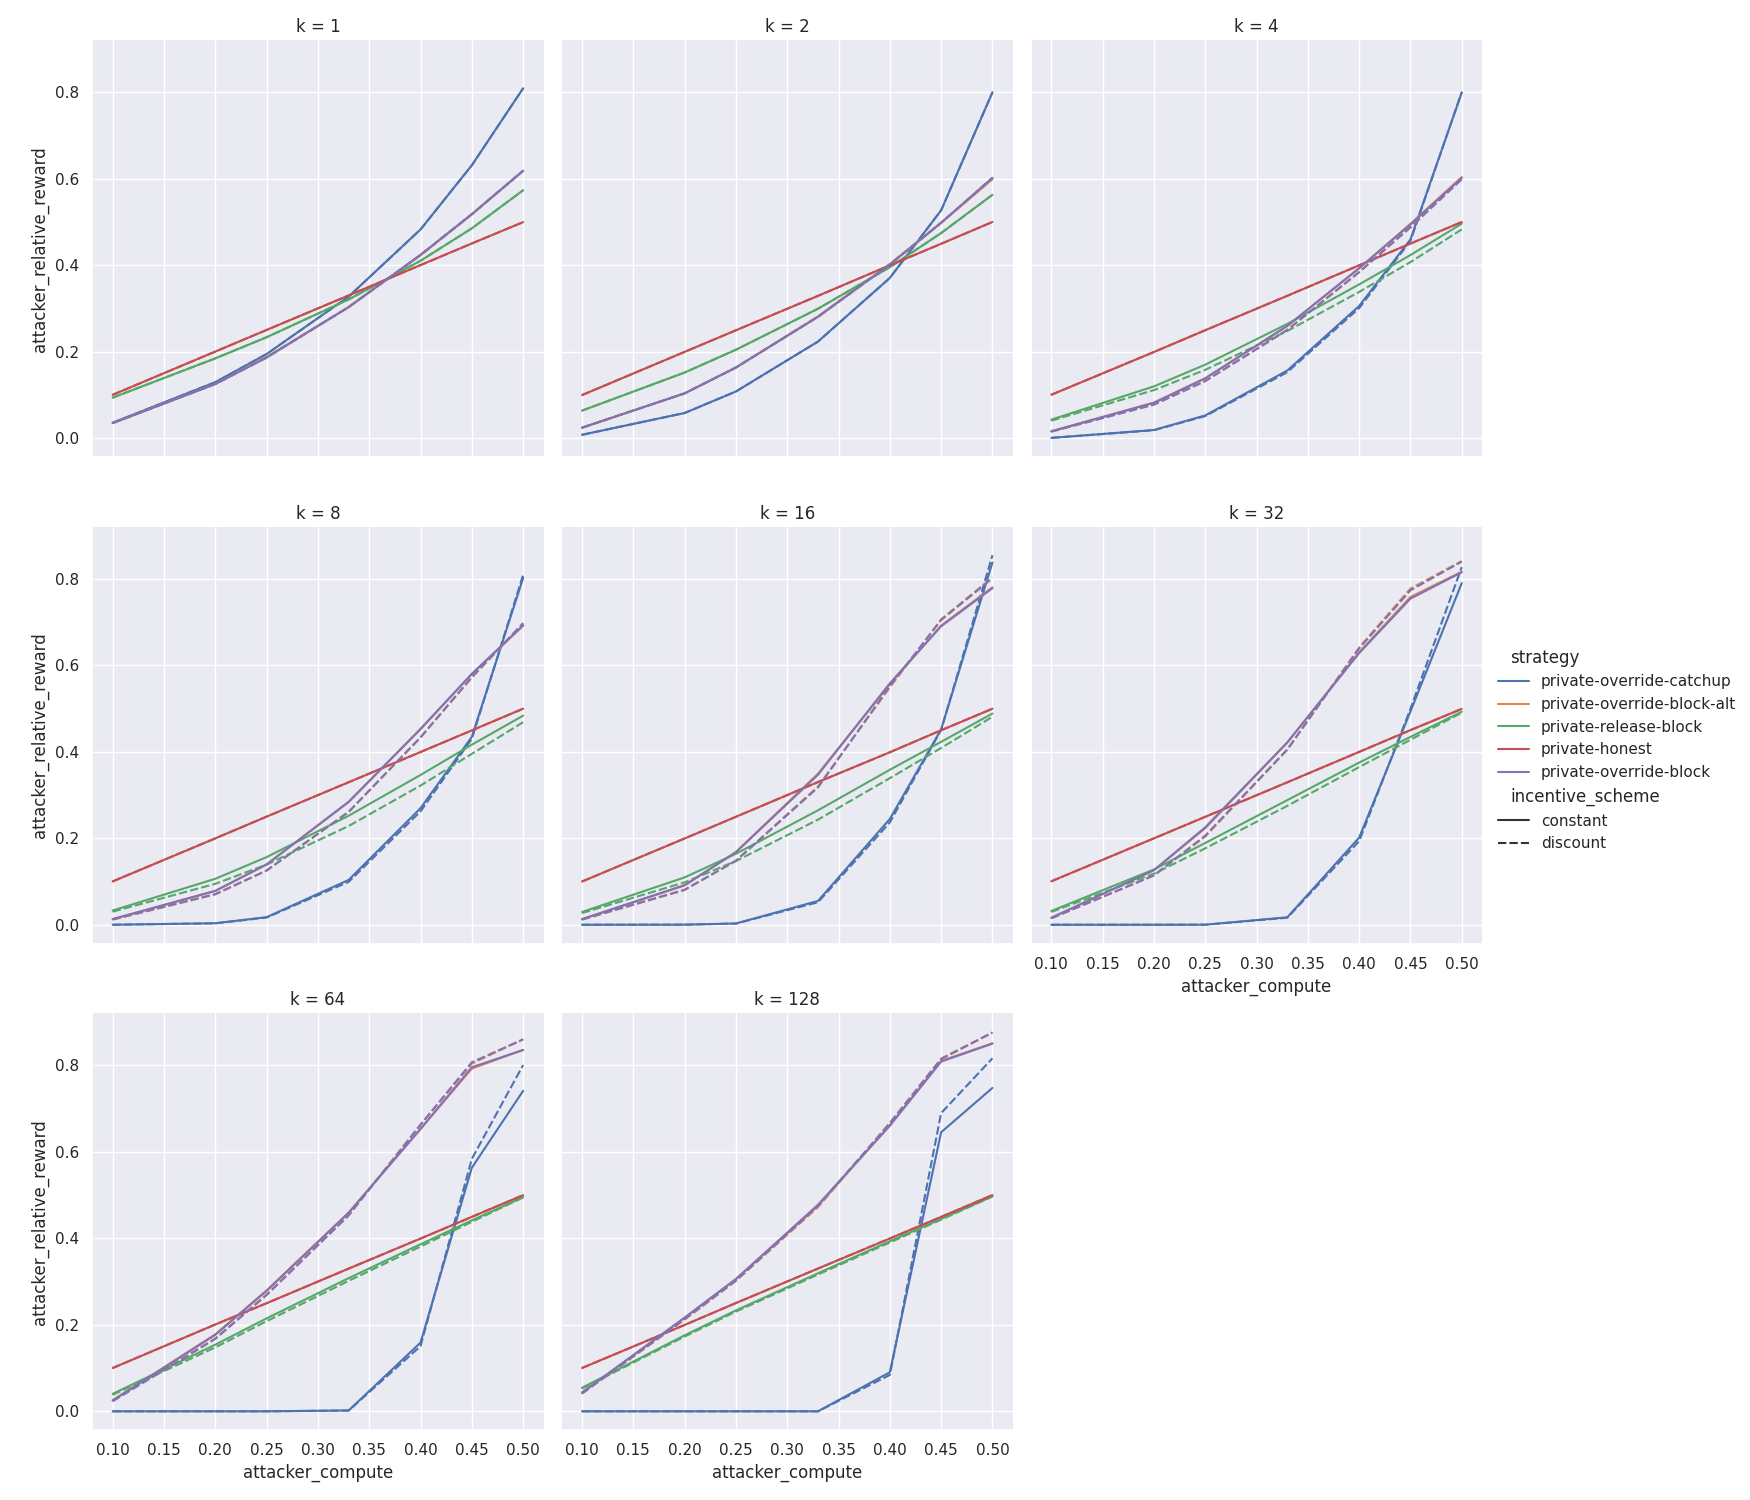

In [36]:
ax = sns.relplot(
    data=d,
    x="attacker_compute", y="attacker_relative_reward", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_relative.png")

<IPython.core.display.Javascript object>


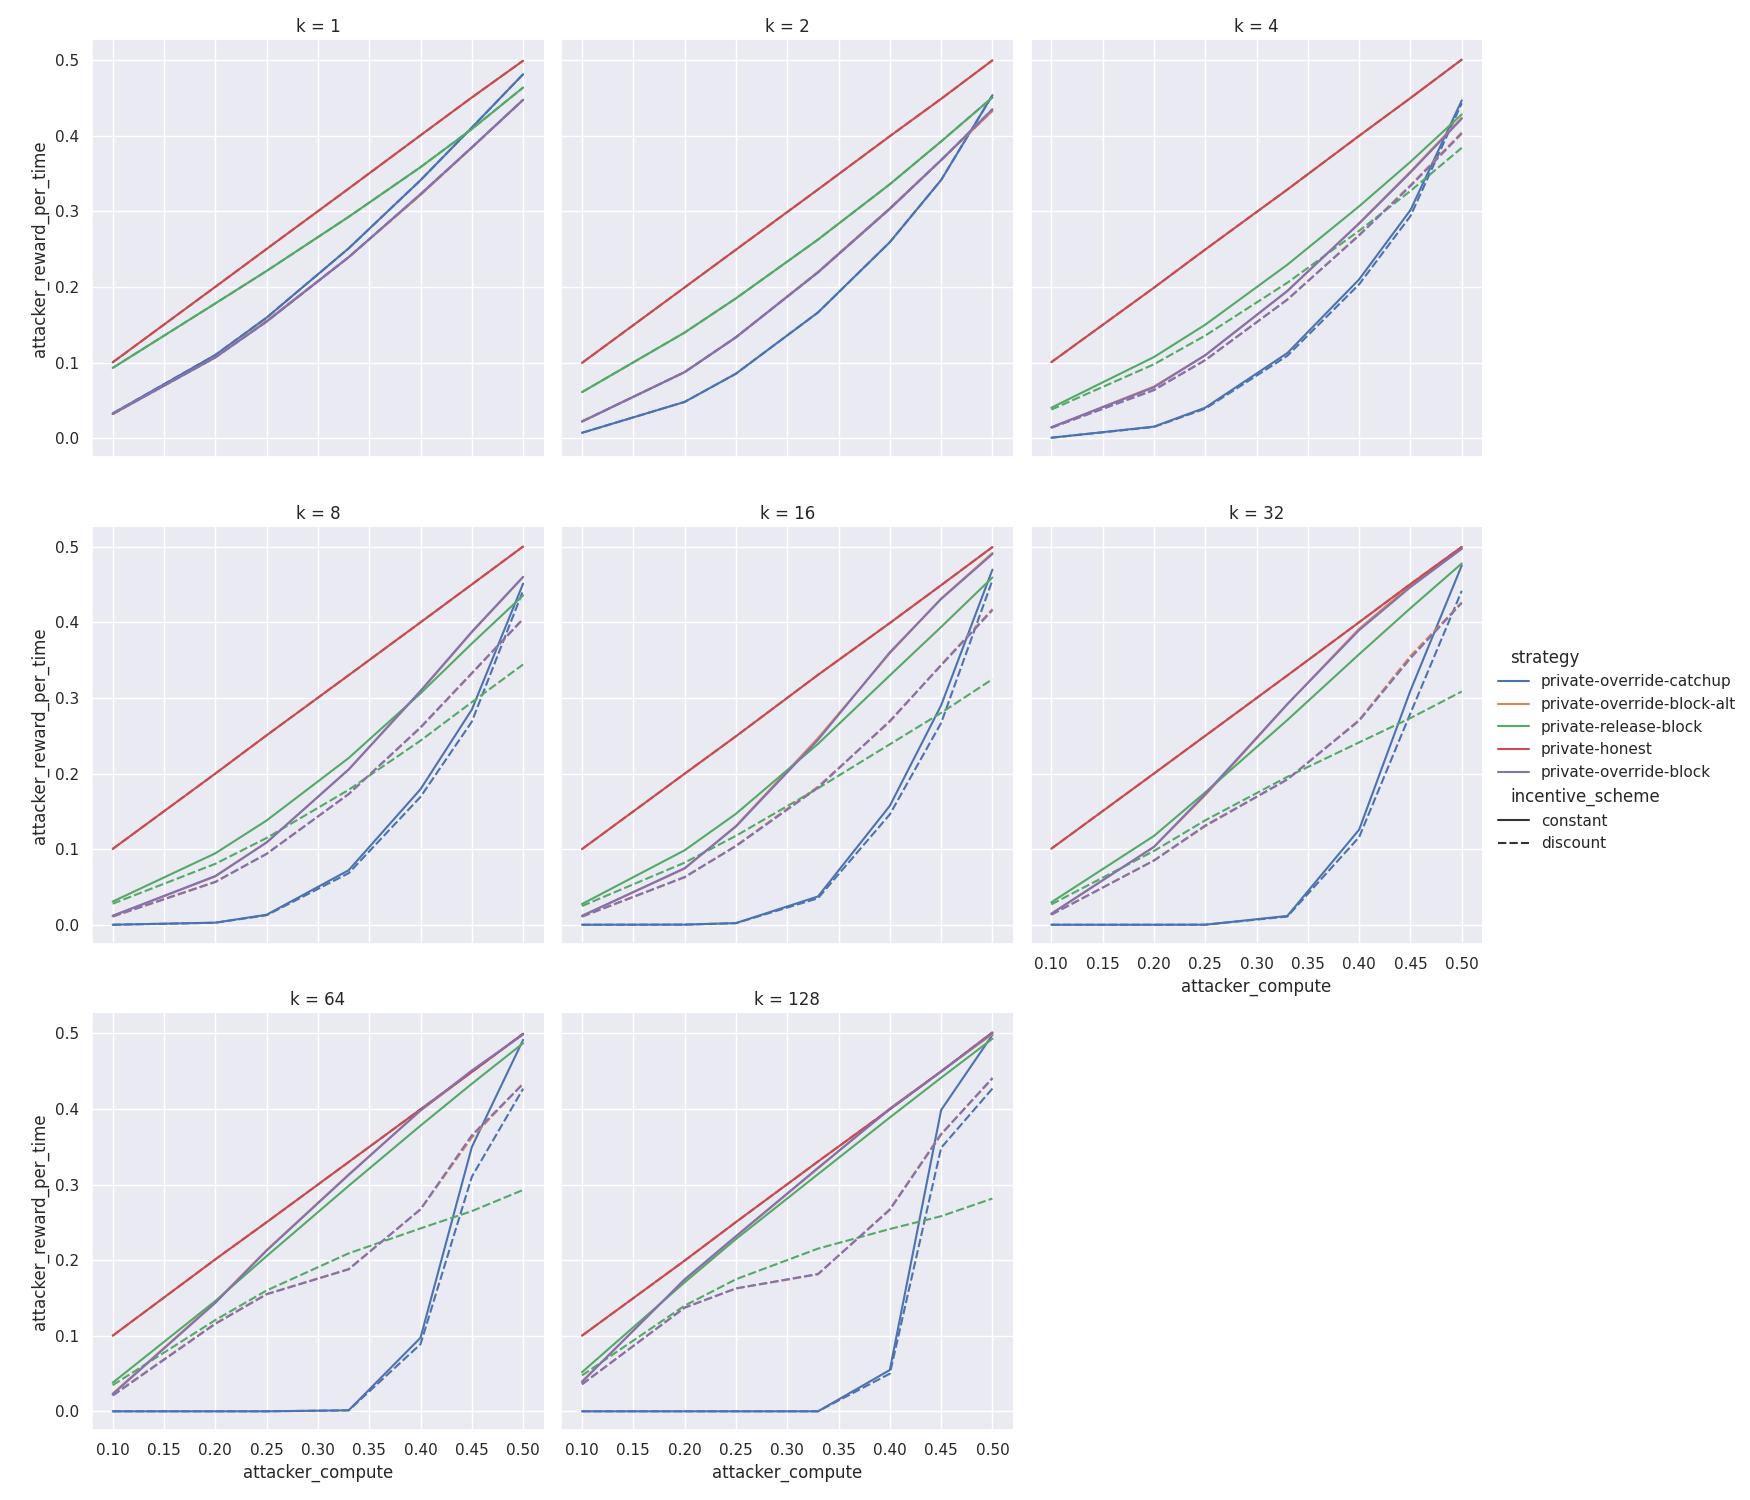

In [35]:
ax = sns.relplot(
    data=d,
    x="attacker_compute", y="attacker_reward_per_time", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_absolute.png")

<IPython.core.display.Javascript object>


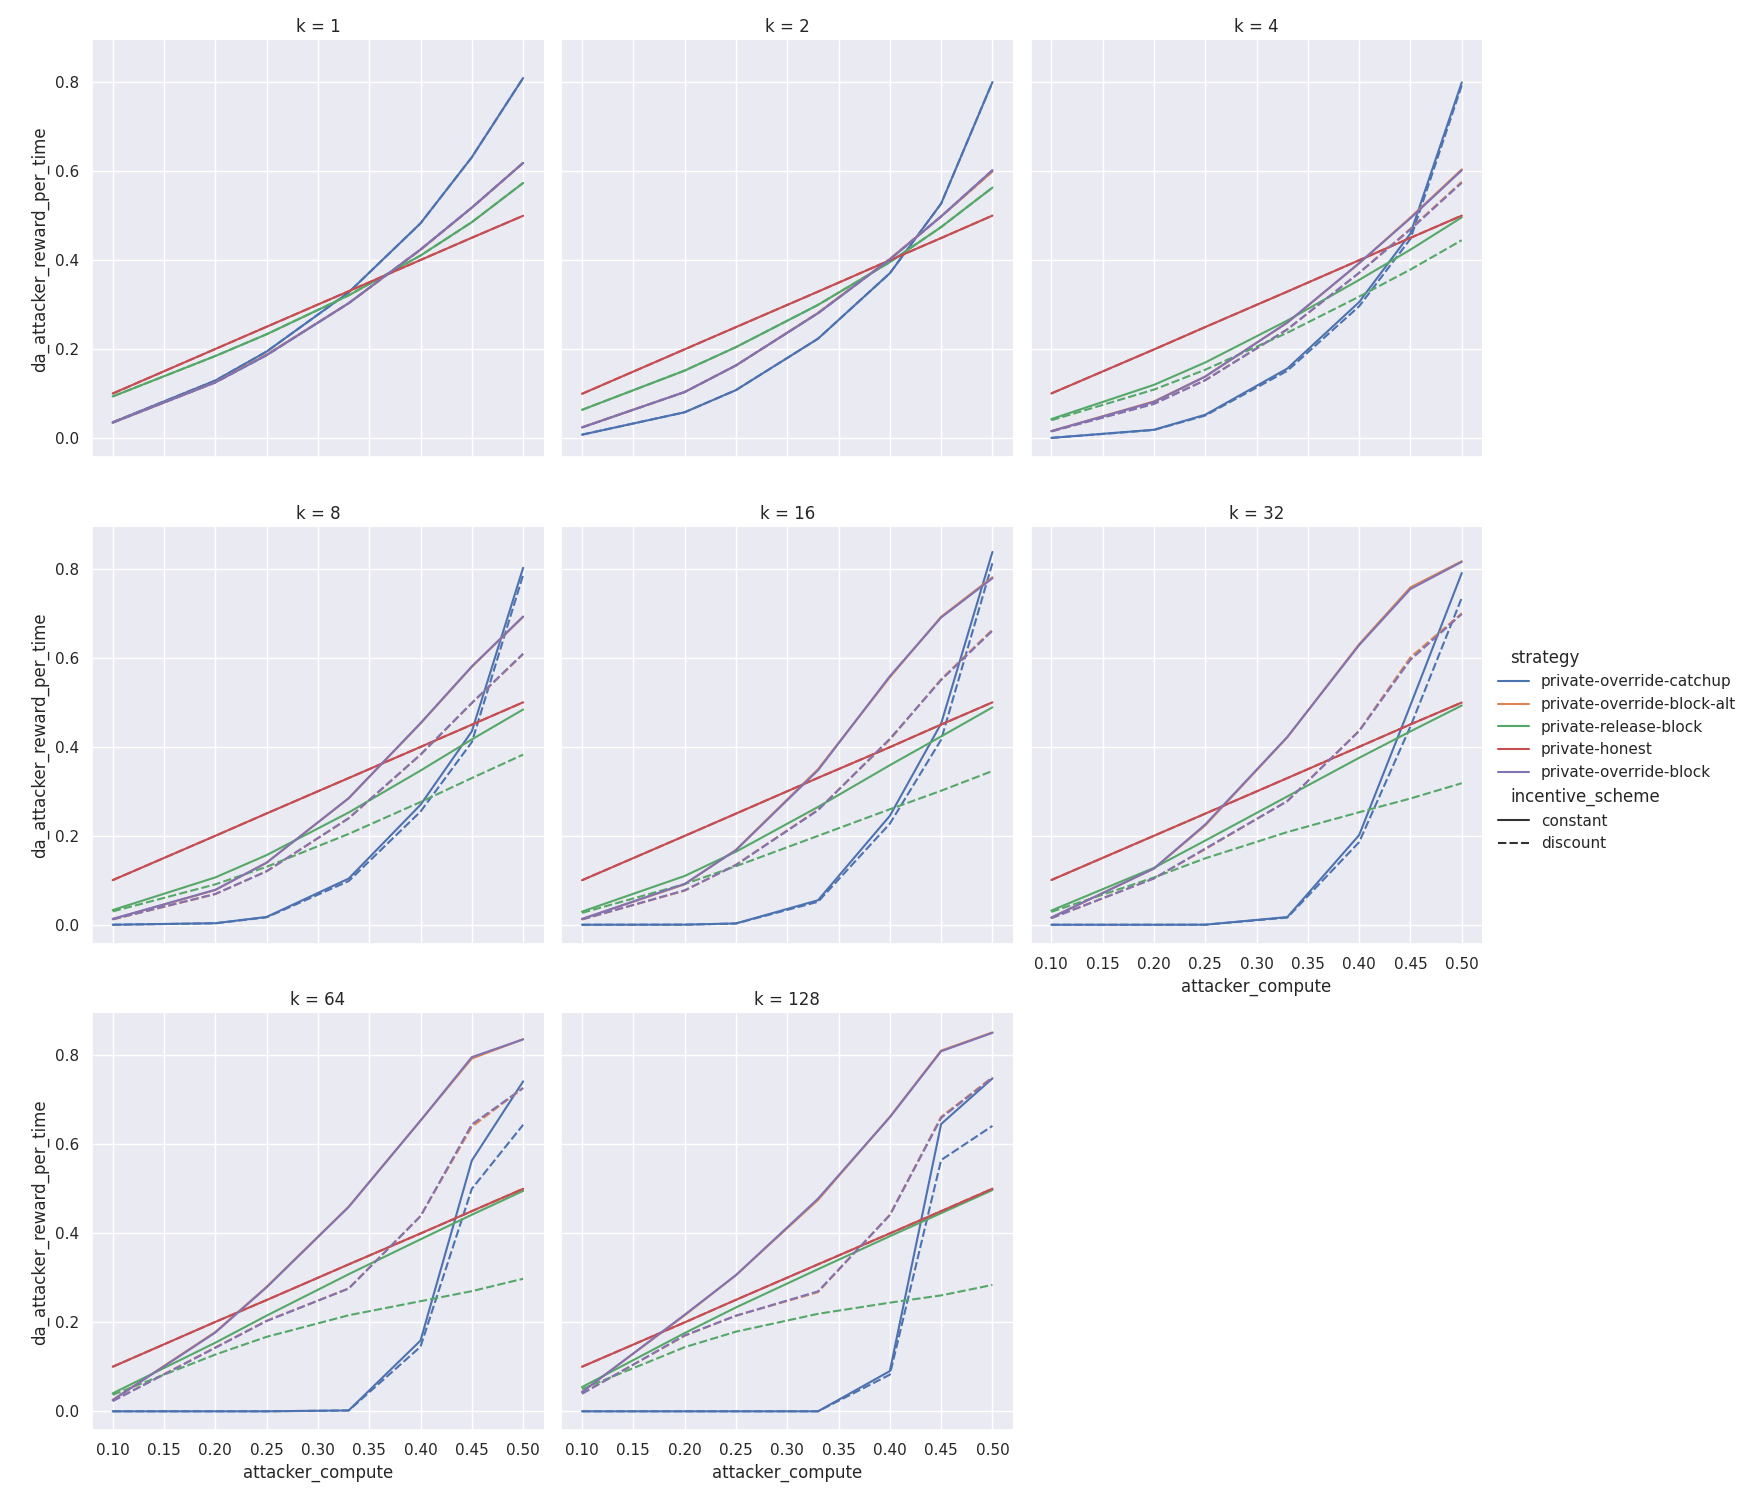

In [34]:
ax = sns.relplot(
    data=d,
    x="attacker_compute", y="da_attacker_reward_per_time", col="k", col_wrap=3,
    hue="strategy", style="incentive_scheme", kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")

<IPython.core.display.Javascript object>


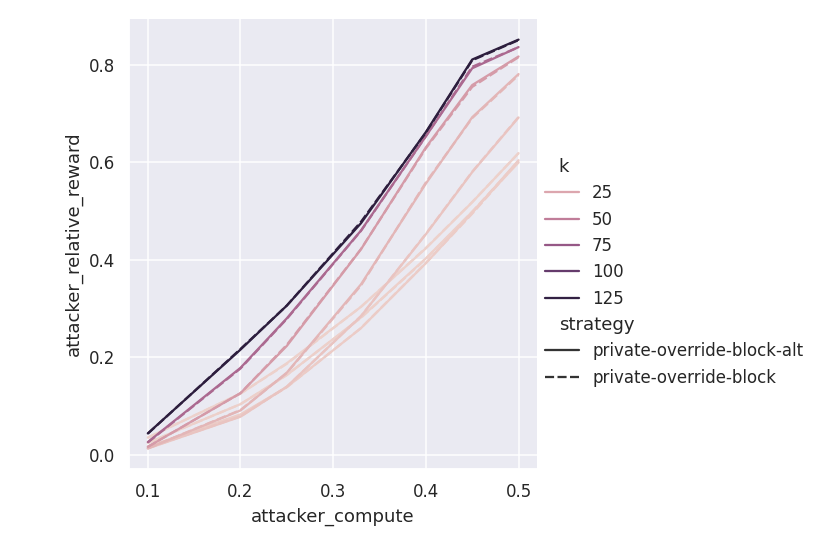

In [9]:
# does numerical implementation line up with non-numerical implementation of policiy?
dd = d
dd = dd[(dd['strategy']=='private-override-block') | (dd['strategy']=='private-override-block-alt')]
dd = dd[(dd['incentive_scheme']=='constant')]
sns.relplot(
    data=dd,
    x="attacker_compute", y="attacker_relative_reward", hue="k",
    style="strategy", kind="line",
)
# It does line up!